In [1]:
import os
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import sklearn
import math
import random

In [2]:
imgref = cv2.imread("cereal.jpg")
reference1 = cv2.cvtColor(imgref,cv2.COLOR_BGR2RGB)
referencegray1 = cv2.cvtColor(reference1, cv2.COLOR_BGR2GRAY)

targetl = cv2.imread('cereal_l.jpg')
targetr = cv2.imread('cereal_r.jpg')
targettl = cv2.imread('cereal_tl.jpg')
targettr = cv2.imread('cereal_tr.jpg')

In [3]:
def Matches(image1,image2):
    my_SIFT_instance = cv2.SIFT_create()

    keypoints_1, descriptors_1 = my_SIFT_instance.detectAndCompute(image1,None)
    keypoints_2, descriptors_2 = my_SIFT_instance.detectAndCompute(image2,None)
    
    feature = cv2.FlannBasedMatcher()
    matches = feature.knnMatch(descriptors_1,descriptors_2, k=2) 
    
    good = []
    mdis = []
    MatchDistance = []
    for m,n in matches:
        md = m.distance
        nd = n.distance
        mdis.append(md) 
        ratio = md / nd
        tau = 0.8
        if ratio < tau:
            good.append([m])
            MatchDistance.append(md)    
    return keypoints_1, descriptors_1, keypoints_2, descriptors_2, good

In [4]:
def Rotate(ref):    
    referencegray1 = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)    
    height, width = referencegray1.shape[:2]
    center = (width/2, height/2)

    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=15, scale=0.5)
    rotated_referencegray1 = cv2.warpAffine(src=referencegray1, M=rotate_matrix, dsize=(width, height))
    
    return rotated_referencegray1

In [7]:
def Affine(ref,tar):  
    
    referencegray1 = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY) 
    target = cv2.cvtColor(tar,cv2.COLOR_BGR2RGB)
    targetgray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1, keypoints_2, descriptors_2, good = Matches(referencegray1,targetgray)

    ref_pts = np.float32([keypoints_1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    img_pts = np.float32([keypoints_2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

    m, _ = cv2.estimateAffinePartial2D(ref_pts,img_pts, method = cv2.RANSAC)

    colorreference = ref.copy()
    imagewarp = cv2.warpAffine(colorreference, m, (targetgray.shape[1],targetgray.shape[0]),borderValue = (0,0,0))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Reference Image")
    plt.imshow(referencegray1,cmap = 'gray')

    plt.subplot(1,3,2)
    plt.title("Target Image")
    plt.imshow(targetgray,cmap = 'gray')

    plt.subplot(1,3,3)
    plt.title("Affine Image")
    plt.imshow(imagewarp)

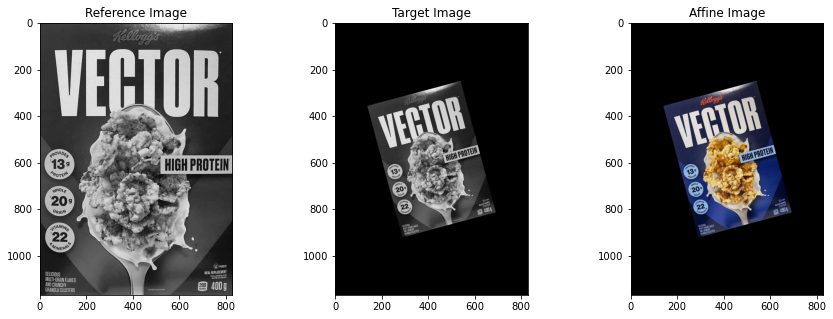

In [8]:
target = Rotate(reference1)
Affine(reference1,target)

In [9]:
def Homography(ref,tar):
    #cereal_l = cv2.imread('cereal_l.jpg')
    target = cv2.cvtColor(tar,cv2.COLOR_BGR2RGB)
    targetgray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
    
    referencegray1 = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1, keypoints_2, descriptors_2, good = Matches(referencegray1,targetgray)

    ref_pts = np.float32([keypoints_1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    img_pts = np.float32([keypoints_2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

    m, _ = cv2.findHomography(ref_pts,img_pts, method = cv2.RANSAC)

    colorreference = ref.copy()
    #plt.imshow(colorreference)
    imagewarp = cv2.warpPerspective(colorreference, m, (targetgray.shape[1],targetgray.shape[0]))

    temp = cv2.cvtColor(targetgray, cv2.COLOR_GRAY2BGR)
    for i in range (temp.shape[0]):
        for j in range (temp.shape[1]):
            if (imagewarp[i][j].all() == 0):
                imagewarp[i][j] = temp[i][j]
            if (imagewarp[i][j].all() == 0):
                imagewarp[i][j] = temp[i][j]
     
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("Reference Image")
    plt.imshow(referencegray1,cmap = 'gray')

    plt.subplot(1,3,2)
    plt.title("Target Image")
    plt.imshow(targetgray,cmap = 'gray')

    plt.subplot(1,3,3)
    plt.title("Overlay from received homography")
    plt.imshow(imagewarp)

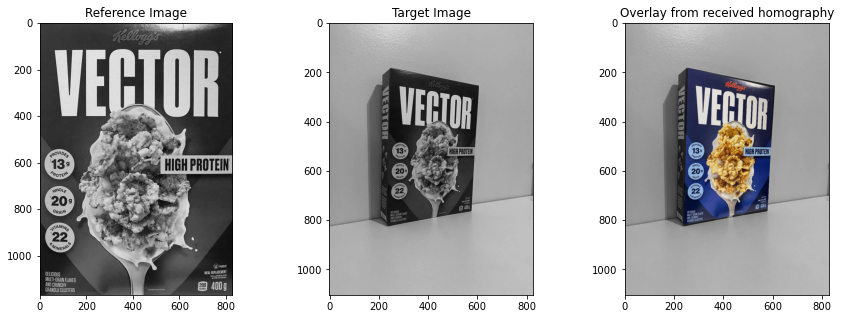

In [10]:
Homography(reference1,targetl)

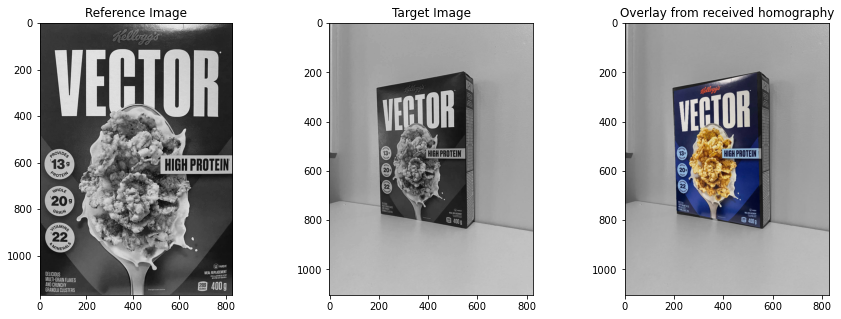

In [11]:
Homography(reference1,targetr)

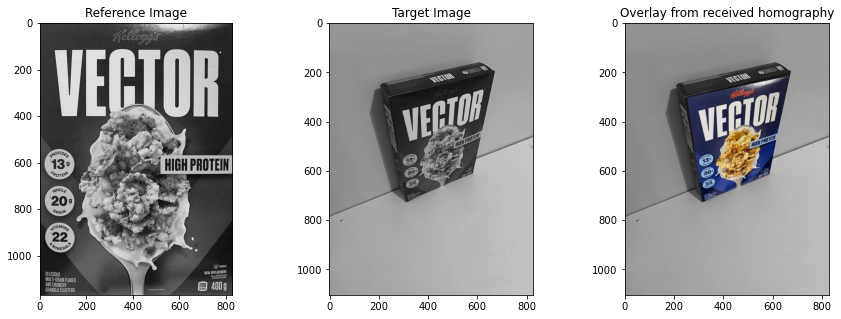

In [12]:
Homography(reference1,targettl)

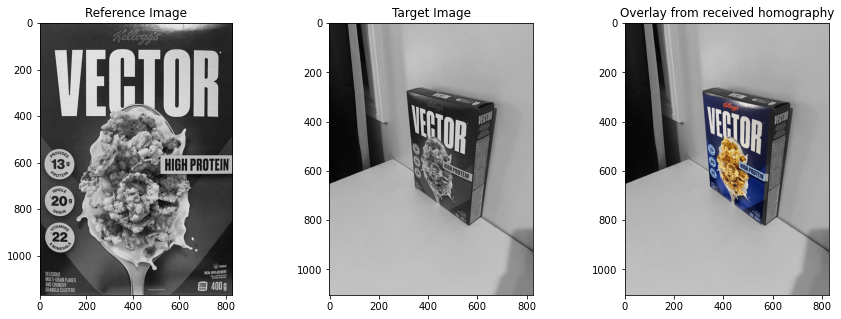

In [13]:
Homography(reference1,targettr)